# Предсказание результатов шахматных партий

В данном файле представлена попытка предсказать результаты шахматных партий с помощью несколькиъ моделей. 
В качестве исходных данных взят датасет из Kaggle. Вопрос о том, можно ли использовать данные из обновляемых баз открыт.
Также открыт вопрос о том, можно ли улучшить прогноз с помощью использования дополниетльных данных (места проведения партии, турнирного положения и т.п.)

## Этап 1. Подготовка исходных данных.

На данном этапе мы просто выгружаем данные из файла, стандартно их разбиваем и проверяем, что всё хорошо. Именно на этом этапе нужны будут изменения, если, например, мы захотим вытаскивать онлайн результаты по API

In [238]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz


import scipy

# будем отображать графики прямо в jupyter'e
%pylab inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [239]:
# Импорт данных и последующая обработка
data = pd.read_csv("training_data.csv")
data['Score']=data['Score']+1
# ВНИМАНИЕ! 
# Здесь и далее будет использовать необычная схема начисления очков: поражение 1.0, ничья 1.5, победа 2.0
# Это сделано для корректной работы части функций (0 означает отсутствие результата).
# Это значит, что прямые формулы рейтингов и ожидания значений просто так использовать нельзя, нужно адаптировать к текущей схеме
data=data.rename(index=str, columns={"Month #": "m", "White Player #": "w", "Black Player #": "b", "Score": "s"})
# Длинные заголовки полей использовать трудно, переименовываем их
data.head(3)

,m,w,b,s
0,1,73,1246,1.5
1,1,73,5097,1.5
2,1,73,5104,1.5


In [240]:
# Разеделение исходных данных на тренировочную и тестовую выборку
tr, tst=train_test_split(data.values,test_size=0.3, random_state=17)
# Разделение 70 на 30
ds=pd.DataFrame(tr, columns=data.columns)
# Так будет называться основной массив данных, с которыми будем работать
f=pd.DataFrame(tst, columns=data.columns)
# Так будет называть массив данных, которые мы будем пытаться предсказывать
x=f[['m', 'w', 'b']]
y=f['s']
# Кроме того, тестовую выборку разделили на массив свойств и массив результатов

In [241]:
ds.describe()

,m,w,b,s
count,45537.000000,45537.000000,45537.000000,45537.000000
mean,61.550388,4367.526868,4343.243714,1.546314
std,31.826493,2496.925468,2498.927717,0.371494
min,1.000000,1.000000,1.000000,1.000000
25%,35.000000,2155.000000,2124.000000,1.500000
50%,67.000000,4435.000000,4394.000000,1.500000
75%,93.000000,6554.000000,6514.000000,2.000000
max,100.000000,8631.000000,8631.000000,2.000000


In [5]:
f.describe()

,m,w,b,s
count,19516.000000,19516.000000,19516.000000,19516.000000
mean,61.561642,4348.190203,4342.763835,1.544092
std,31.893540,2491.979205,2484.869720,0.370360
min,1.000000,1.000000,1.000000,1.000000
25%,34.000000,2106.000000,2129.000000,1.500000
50%,67.000000,4422.000000,4399.000000,1.500000
75%,93.000000,6525.500000,6474.000000,2.000000
max,100.000000,8631.000000,8631.000000,2.000000


In [6]:
# Данные разбиты, распределения правдоподобны, всё хорошо. Данные готовы

## Этап 2. Построение вспомогательных функций и метрик качества.

Метрики качества - функции, с помощью которых мы будем сравнивать модели с дейсвтительностью и между собой. Вспомогательные функции просто помогут абстрагироваться от лишнего

In [7]:
# Определяем метрики качества
def comp(f,y):
    y=list(y)
    return np.sum((abs(y - f['s'] )**2)/(max(abs(y - f['s'] )**2)))
# Первая и быстрая метрика - это квадратичное отколнение по всей дистанции, отнесённое к максимумальному несовпадению
# Логика предельно понятна: чем больше расхождение в каждой точке, тем эта величина больше. 
# Сумма отклонений на дистанции - единое число. У идеальной модели оно равно нулю, далее чем больше, тем хуже модель. 
# Максимальный разброс в знаменателе - попытка дать какой-то модельный смысл самому числу. 

def corr(f,y):
    return scipy.stats.pearsonr(y, f['s'])[0]
# Вторая метрика качества - коэффициент корреляции Пирсона. Старая добрая корреляция. 
# С её помощью попробуем отсекать тривиальные решение и следить за переобучением. 

def count(f,y):
    n=len(y) # размер массива
    f['y']=list(y)
    f['m']=np.where((f['y']-f['s']==0),1,0)
    p=sum(f['m'])
    return float(p)/n
#  Третья метрика - просто доля точных попаданий. Простая и понятная.

def acm(f,y):
    print("Sqr_div: ", comp(f,y))
    print("Correl: ", corr(f,y))
    print("Share: ", count(f,y))
# Просто печатаем всё вместе

In [8]:
# Функция получения статистики
# На вход подаём партии с результатами, на выходе - статистика по игрокам, сыгранным партиям, набранным очкам и т.п.
# Если на входе таблица с играми без результатов, то выводим просто список игроков, статистику игр и столбец нулевого рейтинга
# Эту таблицу вполне можно дополнять
def plst(ds):
    if 's' in ds.columns: # проверяем, есть ли в исходных данных столбец с результатами
        w=ds.groupby(['w'])['s'].agg([np.sum, np.mean, np.count_nonzero])
        # сгруппировали партии по игрокам, играющими белыми: сумма очков, среднее, число игр
        w=w.reset_index()
        w=w.rename(index=str, columns={"w": "id", "sum": "sum_w", "mean": "mean_w", "count_nonzero": "games_w"})
        # так как потом будут ещё и чёрные, требуется переименовать столбцы
        w['id']=w['id'].astype('Int64')
        # ID - это целое число, много где дальше это будет важно

        b=ds.groupby(['b'])['s'].agg([np.sum, np.mean, np.count_nonzero])
        b=b.reset_index()
        b=b.rename(index=str, columns={"b": "id", "sum": "sum_b", "mean": "mean_b", "count_nonzero": "games_b"})
        b['id']=b['id'].astype('Int64')
        # аналогично для чёрных

        r=pd.merge(w, b, how = 'left', left_on='id', right_on='id')
        # Собрали данные для чёрных им белых
        # N.B. Использована специфичная фунция, может не работать на третьем Питоне
        # N.B. При таком подходе из таблицы пропадают те, кто не сыграл ни одной игры белыми. 
        # На точность рейтинга это не повлияет, но проверку на наличие в таблице делать надо
        r=r.fillna(0)
        # Обязщательная процедура после джойнов

        r['sum_tot']=r['sum_w']+r['sum_b']
        r['games_tot']=r['games_w']+r['games_b']
        # Данные для игр за оба цвета
        r['rat']=0
        # Существование этого поля нам сделаем лёгкой жизнь в будущем
        return r
    else: 
        # ветка на случай, если результатов нет
        w=ds.groupby(['w'])['w'].agg([np.count_nonzero])
        # сгруппировали партии по игрокам, играющими белыми: сумма очков, среднее, число игр
        w=w.reset_index()
        w=w.rename(index=str, columns={"w": "id", "count_nonzero": "games_w"})
        # так как потом будут ещё и чёрные, требуется переименовать столбцы
        w['id']=w['id'].astype('Int64')
        # ID - это целое число, много где дальше это будет важно

        b=ds.groupby(['b'])['b'].agg([np.count_nonzero])
        b=b.reset_index()
        b=b.rename(index=str, columns={"b": "id", "count_nonzero": "games_b"})
        b['id']=b['id'].astype('Int64')
        # аналогично для чёрных
        r=pd.merge(w, b, how = 'left', left_on='id', right_on='id')
        r=r.fillna(0)
        # Обязщательная процедура после джойнов
        r['games_tot']=r['games_w']+r['games_b']
        r['rat']=0
        return r

In [9]:
# Функция, которая подтягивает рейтинг из модели к реальным партия по id игроков
def defr(x, f):
    r=x.merge(f, how = 'left', left_on='w', right_on='id')
    # подтянули к белым их рейтинг
    r=r[['m', 'w', 'b', 'rat']]
    #  убрали лишние столбцы
    r=r.rename(index=str, columns={"rat": "w_rat"})
    # не забыли переименовать: мы взяла пока рейтинг только белых
    r=r.merge(f, how = 'left', left_on='b', right_on='id')
    r=r[['m', 'w', 'b' ,'w_rat', 'rat']]
    r=r.rename(index=str, columns={"rat": "b_rat"})
    # аналогичная процедура для чёрных
    r=r.fillna(0)
    return r

In [10]:
# Функции оценки распределения ошибок
# Так как результата партии всего три, можно составить матрицу 3 на 3, 
# где по одной оси будет предсказанный результат, а по другой - отклонение истины от него
# Такая матрица поможет в поиске систематичесих ошибок и подборе параметров

# Функция выводит матрицу. На вход сначала подаётся датасет с предсказывающей моделью, потом - столбец реальных значений
# На выходе - матрица три на три
def mtrx(f,y):
    f['dif']=f['s']-list(y)
    # различие факта и модели
    f['i']=f.index.values
    g=f.groupby(['s','dif'], as_index=0).agg({'i': lambda x: x.nunique()})
    # группируем по числу исходов и ошибок
    p=g.pivot(index='dif', columns='s', values='i')
    # выводим в удобном матричном виде
    p=p.fillna(0)
    return p

# Функция, аналогичная прошлой, только выдаёт данные в нормализованнм виде
def mtrxn(f,y):
    m=mtrx(f,y)
    nn=sum(sum(m))
    #нормализуем на максимум
    return m/nn



In [11]:
# Функции построения графиков
# Простейший график. Выводит модель и факт. Третий параметр функции - число взятых точек для сравнения 
def pl(f, y, n):
    plot(range(n), f['s'][0:n], range(n), y[0:n])
    # ну и просто график глазами посмотреть

In [12]:
# Функции построены, проверены, всё хорошо. Можно начинать строить модели!

## Этап 3. Построение гипотез

В данном разделе мы будем строить различные модели, которые на основании данных из набора ds постараются на нанных из набора x спрогнозировать то, что будет в столбце y. Качество работы моделей определяют меьтрики качества и здравый смысл. 

### Модель №0. Полный рандом

Нулевая модель просто генерирует один из трёх возможных результатов в каждой партии. Ожидается, что модель будет плохой, а любую работающую модель имеет смысл сравнивать только в том случае, если она будет лучше нулевой.
Простейшая модель не имеет параметров настройки, не смотрит ни на какие данные, просто выдаёт результат.

In [13]:
# Функция нулевой модели
def r0(x): # на входе только датафрейм x
    n=int(len(x['m']))
    # определяем длину выборки
    rnd=np.random.rand(n,1)
    # генерируем одномерный массив случайных чисел размером n 
    rnd=(((np.round((rnd*100)%2,0)))/2)+1
    # Ставим в соответствие каждому случайному число одно из трёх чисел: 1.0, 1.5, 2.0
    r0=pd.DataFrame(rnd, columns=['s'])
    # Собираем датафрейм с результатом
    return r0

In [14]:
acm(r0(x),y)

('Sqr_div: ', 5203.25)
('Correl: ', -0.0062081626345738671)
('Share: ', 0.3584238573478172)


/opt/python/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


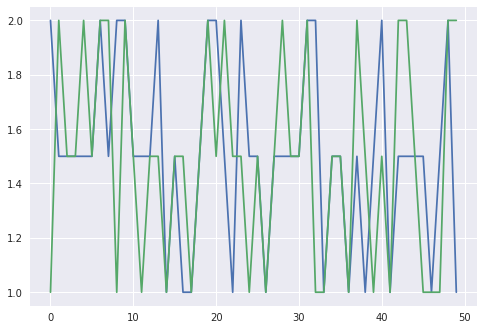

In [15]:
pl(r0(x), y, 50)

In [16]:
# Отклоенение нам пока ничего не сказало, но отрицательная корреляция и общее число непопадений 
# говорят нам о том, что модель, как и ожадли, плоха

### Модель №1. Средний по больнице

В первой модели мы выскажем гипотезу о том, что результат следующей партии может предсказать среднее число очков за партию данного игрока.
Тот, кто раньше часто выигрывал будет и дальше выигрывать. А тот, кто проигрывал - будет проигрывать.

Конкретизация модели. Цвет не имеет значения, порядок партий не имеет значения. Тот, у кого выше рейтинг, всегда побеждает.

In [17]:
# Определяем функцию новой модели
def r1(ds, x):
    rb=plst(ds)
    # вытащили и сохранили статистику
    rb['rat']=rb['sum_tot']/rb['games_tot']
    # единый рейтинг у человека за всё время по выбранному параметру
    rb=rb.fillna(0)
    r1=defr(x, rb)
    # Притягиваем полученный нами рейтинг к каждой партии из тренровочной выборки
    r1['s']=np.where(r1['w_rat']>r1['b_rat'], 2.0, np.where(r1['w_rat']<r1['b_rat'],1.0, 1.5))
    # Предсказываем результат. У кого больше, того и тапки. Ничья только если все рейтинги равны
    return r1

In [18]:
# Выводим метрики качества
acm(r1(ds, x),y)

('Sqr_div: ', 7176.0)
('Correl: ', 0.045515532319713198)
('Share: ', 0.2979606476737036)


In [19]:
# Положительная корреляция - хорошо, но отклонение хуже, чем у рандома. Как так?

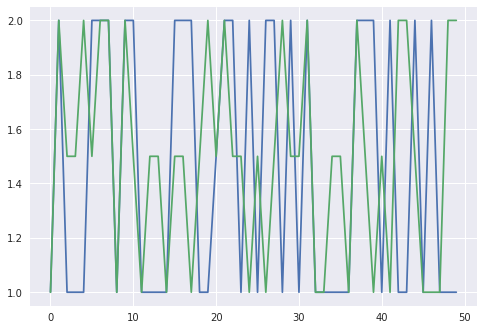

In [20]:
pl(r1(ds, x), y, 50)

In [21]:
mtrx(r1(ds,x),y)

s,1.0,1.5,2.0
dif,,,
-1.0,2916.0,0.0,0.0
-0.5,4259.0,119.0,0.0
0.0,2398.0,162.0,3255.0
0.5,0.0,86.0,4236.0
1.0,0.0,0.0,2085.0


In [22]:
mtrxn(r1(ds,x),y)

s,1.0,1.5,2.0
dif,,,
-1.0,0.149416,0.000000,0.000000
-0.5,0.218231,0.006098,0.000000
0.0,0.122874,0.008301,0.166786
0.5,0.000000,0.004407,0.217053
1.0,0.000000,0.000000,0.106835


In [23]:
# Можно увидеть низкую долю предсказанных ничьих. И 25 процентов непопадений на очко и более. 
# Модель откровенно плоха, но, возможно, её можно быстро улучшить

### Модель 1.1

Небольшое улучшение первой. 
Оно состоит в том, что игрок побеждает, если разность рейтингов выше параметра k, иначе - ничья.
Параметр определим экспериментально.

In [24]:
k=1.9 # Единственный параметр модели

In [25]:
# Определяем функцию новой модели
def r11(ds, x):
    rb=plst(ds)
    # вытащили и сохранили статистику
    rb['rat']=rb['sum_tot']/rb['games_tot']
    # единый рейтинг у человека за всё время по выбранному параметру
    rb=rb.fillna(0)
    r11=defr(x, rb)
    # Притягиваем полученный нами рейтинг к каждой партии из тренровочной выборки
    r11['s']=np.where((r11['w_rat']-r11['b_rat'])>k, 2.0, np.where((r11['b_rat']-r11['w_rat'])>k,1.0, 1.5))
    # Предсказываем результат. У кого больше, того и тапки. Ничья только если все рейтинги равны
    return r11

In [26]:
# Определяем оптимальное значение параметра
# Просто пробегаем в цикле все приемлемые значения
lk=[]
lq=[]
lc=[]
for i in range(22):
    k=0.1+i*0.1 #первое значение параметра 0.1, последнее - 2.3
    r=r11(ds,x)
    lk.append(k)
    lq.append(comp(r, y))
    lc.append(corr(r,y))

/opt/python/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


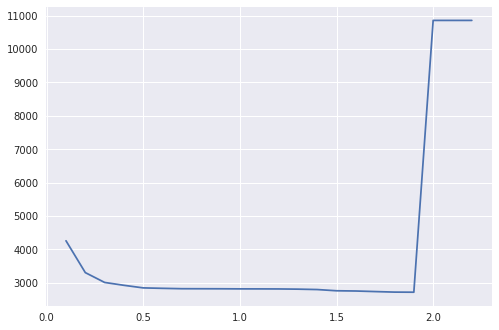

In [27]:
plot(lk, lq)

In [28]:
# Как только параметр стал таким, что ВСЕ партии прогнозируются сыгранными вничью, результат стал хуже рандома

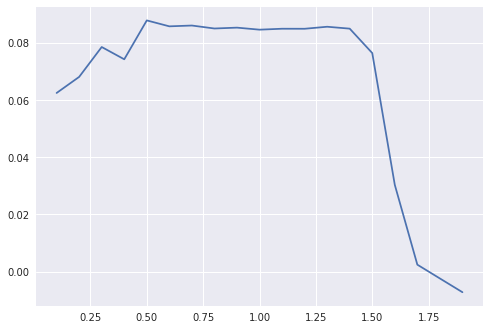

In [29]:
plot(lk, lc)

In [30]:
# Корреляция слабо падает ещё раньше
# Таким образом, оптимальное значение параметра - это 0.5

In [31]:
k=0.5
# Выводим метрики качества
acm(r11(ds, x),y)

('Sqr_div: ', 2849.75)
('Correl: ', 0.087909598248360921)
('Share: ', 0.45127075220332036)


In [32]:
# Лучше рандома по всем показателям. Плохо, конечно

In [33]:
mtrx(r1(ds,x),y)

s,1.0,1.5,2.0
dif,,,
-1.0,2916.0,0.0,0.0
-0.5,4259.0,119.0,0.0
0.0,2398.0,162.0,3255.0
0.5,0.0,86.0,4236.0
1.0,0.0,0.0,2085.0


In [34]:
mtrxn(r1(ds,x),y)

s,1.0,1.5,2.0
dif,,,
-1.0,0.149416,0.000000,0.000000
-0.5,0.218231,0.006098,0.000000
0.0,0.122874,0.008301,0.166786
0.5,0.000000,0.004407,0.217053
1.0,0.000000,0.000000,0.106835


In [35]:
# Ничейная смерть побеждена, но ошибка "на два результат" в 25 процентов случаев не исправилась 

### Модель №2. Официальный рейтинг ЭЛО

В качестве следующей модели возьмём тот рейтинг, который официально применяется в шахматах (https://ru.wikipedia.org/wiki/Рейтинг_Эло) ровно с теми параметрами. Его предсказательная сила должна быть хорошей.

Основная идея рейтинга ЭЛО в том, что перед каждой партией строится ожидаемый результат этой партии, который сверяется с фактическим. 
Определением результата по рейтингу - вероятностное. Человек, рейтинг которого выше на 200 пунктов, должен побеждать в 76 процентов случаев.
В этой модели мы в первые будет вытаскивать результат конкретной партии.

In [36]:
# Определяем параметры модили
k=40
z=400
#параметры модели, взяты с официального шахматного рейтинга

rst=1600
#начальный рейтинг - более-менее произвольное число

In [37]:
# Первая функция модели, строит текущие рейтинги
# N.B. На данный момент не хранит историю изменений, только актуальные рейтинги
# Сохраняем нужные нам данные в списки, ведём словарь текущих рейтингов и в цикле после каждой партии его обновляем
# Функция вовзращает словарь с самыми актуальными рейтингами на момент запуска
def elo(ds):
    ds=ds.sort_values(by='m')
    #отсортировали по времени
    r2=ds
    r2['w_exp']=0
    r2['b_exp']=0
    # создаём поля для ожидаемых значений, пока пустые
    
    rd=plst(ds) #вытащили статистику из обуцчающей выборкм
    rd=rd[['id', 'rat']] #на самом деле, нам кроме полного списка игроков особо ничего и не нужно
    rd['id']=rd['id'].astype('Int64')
    rd['rat']=rst #положили начальный рейтинг
    lst=list(rd.values)
    drat=dict(lst)
    # конвертировали в словарь, для улучшения скорости
    
    w=list(r2['w'])
    b=list(r2['b'])
    s=list(r2['s'])
    w_exp=list(r2['w_exp'])
    b_exp=list(r2['b_exp'])
    # ковертировали важные поля в списки, так просто быстрее считатеся
    
    n=len(r2['s']) # длина массива
    #n=40
    for i in range(n):
        if drat.get(w[i])<0: 
            rw=rst
        else:
            rw=drat.get(w[i])
        if drat.get(b[i])<0:
            rb=rst
        else:
            rb=drat.get(b[i])
        #проверка если вдруг игрока нет в списке игроков
        
        w_exp[i]=float(1)/(1+pow(10, (-rw+rb)/z))+1
        b_exp[i]=float(1)/(1+pow(10, (-rb+rw)/z))+1
        # формулы расчёта ожидаемого значения партии
        
        db1={w[i]: rw+k*(s[i]-w_exp[i])}
        db2={b[i]: rb+k*(3-s[i]-b_exp[i])}
        # изменение рейтогов исходя из разницы ожидания и действительности
        drat.update(db1)
        drat.update(db2)
        # обновляем словарь текущих рейтингов
    d=drat
    return d

In [38]:
elo(ds).get(1)

1673.4589229523272

In [39]:
def r2(drat,x):
    pdrat=pd.DataFrame(drat.values(), index=drat.keys()) 
    pdrat['id']=pdrat.index
    pdrat['id']=pdrat['id'].astype('Int64')
    pdrat = pdrat.rename(columns={0: 'rat'})
    # конвертировали словарь в датафрейм
    
    r=defr(x, pdrat)
    # подтянули рейтинги к реальным партиям
    r['se']=float(1)/(1+pow(10, (-r['w_rat']+r['b_rat'])/z))+1
    # высчитали ожидаемое значение

    r['s']=np.where((r['se']<1.25),1.0,np.where((r['se']>1.75),2.0,1.5))
    # округлили ожидаемое значение до одного из трёх вариантов
    return r

In [40]:
r2(elo(ds),x).head(3)

,m,w,b,w_rat,b_rat,se,s
0,34.0,1200.0,4432.0,1603.807889,1604.718925,1.498689,1.5
1,9.0,3824.0,8299.0,1713.928009,1615.261966,1.638294,1.5
2,69.0,172.0,6578.0,1638.877572,1594.829415,1.563053,1.5


In [41]:
# Выводим метрики качества
acm(r2(elo(ds),x),y)

('Sqr_div: ', 2737.0)
('Correl: ', 0.15877229643845134)
('Share: ', 0.4602377536380406)


In [42]:
# Это уже что-то. Хотя ожидалось сильно лучше

In [43]:
mtrx(r2(elo(ds),x),y)

s,1.0,1.5,2.0
dif,,,
-1.0,92.0,0.0,0.0
-0.5,229.0,5784.0,0.0
0.0,305.0,8263.0,414.0
0.5,0.0,4218.0,165.0
1.0,0.0,0.0,46.0


In [46]:
mtrxn(r2(elo(ds),x),y)

s,1.0,1.5,2.0
dif,,,
-1.0,0.004714,0.000000,0.000000
-0.5,0.011734,0.296372,0.000000
0.0,0.015628,0.423396,0.021213
0.5,0.000000,0.216130,0.008455
1.0,0.000000,0.000000,0.002357


In [45]:
# Меньше процента ошибки на "2 результата"! Это успех!

In [108]:
r2(elo(ds),x)['s'].value_counts()

1.5    18930
1.0      297
2.0      289
Name: s, dtype: int64

### Модель №3. Пробуем машинное обучение

Попробуем различные методики машинного обучения.

Логичнее всего начать с обычного бинарного дерева. В качестве фичей используем всё, что у нас есть: месяц, id чёрных и белых

In [180]:
def wr_tree(clf_tree, fnames):
    export_graphviz(clf_tree, feature_names=fnames, 
    out_file='small_tree.dot', filled=True)
    # для этого понадобится библиотека pydot (pip install pydot)
    !dot -Tpng 'small_tree.dot' -o 'small_tree.png'

In [184]:
md=4
def r3(ds,x, md):
    tr_x=ds[['m', 'w', 'b']]
    tr_y=ds['s']*10
    tr_y=tr_y.astype('Int64')
    # разделили данные на фичи и результат
    
    rst=17
    # параметры модели
    
    clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=md, random_state=rst)
    # загрузили модель
    clf_tree.fit(tr_x, tr_y)
    # обучились
    r3=pd.DataFrame(clf_tree.predict(x))
    # предсказались
    
    r3=r3.rename(index=str, columns={0: "s"})
    r3['s']=r3['s']/10
    #небольшие шаманства с датафреймом, чтобы было лучше жить
    
    wr_tree(clf_tree, ['m','w', 'b'])
    #и нарисуем картиночку в файл
    return r3

In [186]:
# смотрим параметр md
lk=[]
lq=[]
lc=[]
for i in range(1,10):
    md=i
    rbuf=r3(ds,x, md)
    lk.append(md)
    lq.append(comp(rbuf, y))
    lc.append(corr(rbuf,y))

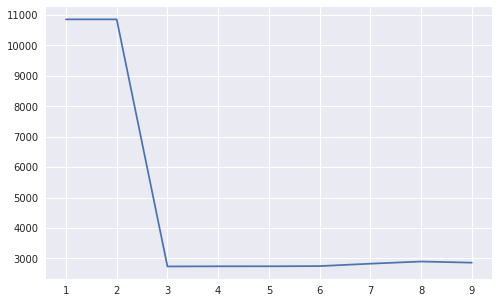

In [188]:
plot(lk,lq)

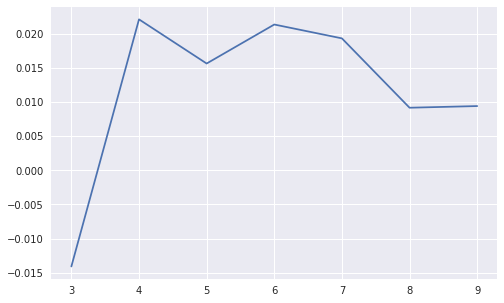

In [189]:
plot(lk,lc)

In [145]:
#md=4 - вариант, который имеет смысл рассмотреть

In [190]:
# Выводим метрики качества
acm(r3(ds,x,4),y)

('Sqr_div: ', 2741.0)
('Correl: ', 0.022095119469931312)
('Share: ', 0.44343103094896497)


In [192]:
# Рехультат не очень

In [191]:
r3(ds,x,4)['s'].value_counts()

1.5    19371
1.0      115
2.0       30
Name: s, dtype: int64

Попробуем в качестве фичи подать среднее число очков, набранных игроком ранее

In [247]:
def r31(ds,x, md):
    st=plst(ds)
    # подтащили статистику
    st['rat']=st['sum_tot']/st['games_tot']
    # подтянем рейтинг из модели 1
    dst=defr(ds, st)
    xst=defr(x,st)
    # подтянули рейтинг по idшнику
    dst['s']=list(ds['s'])
    dst=dst.fillna(0)
    
    x=xst[['m','w_rat', 'b_rat']]
    x=x.fillna(0)
    
    tr_x=dst[['m','w_rat', 'b_rat']]
    tr_y=dst['s']*10
    tr_y=tr_y.astype('Int64')
    # разделили данные на фичи и результат
    
    
    
    rst=17
    # параметр модели
    
    clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=md, random_state=rst)
    # загрузили модель
    clf_tree.fit(tr_x, tr_y)
    # обучились
    r3=pd.DataFrame(clf_tree.predict(x))
    # предсказались
    
    r3=r3.rename(index=str, columns={0: "s"})
    r3['s']=r3['s']/10
    #небольшие шаманства с датафреймом, чтобы было лучше жить
    
    wr_tree(clf_tree, ['m','w_rat', 'b_rat'])
    #и нарисуем картиночку в файл
    return r3

In [255]:
# смотрим параметр md
lk=[]
lq=[]
lc=[]
for i in range(1,10):
    md=i
    rbuf=r31(ds,x,md)
    lk.append(md)
    lq.append(comp(rbuf, y))
    lc.append(corr(rbuf,y))

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.818909 to fit


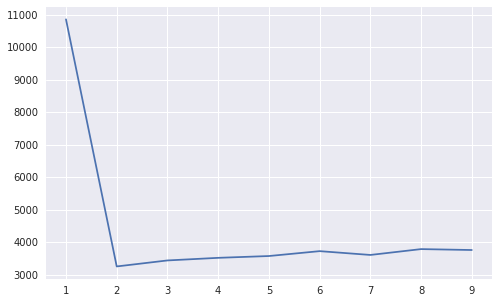

In [256]:
plot(lk,lq)

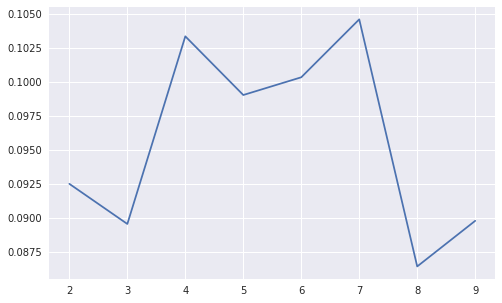

In [257]:
plot(lk,lc)

In [ ]:
# И у нас есть выбор!
# Хорошей может быть и модель с md=2, и с md=4, и с md=7

In [258]:
r31(ds,x,2)['s'].value_counts()

1.5    16232
2.0     1783
1.0     1501
Name: s, dtype: int64

In [259]:
r31(ds,x,4)['s'].value_counts()

1.5    14861
1.0     2337
2.0     2318
Name: s, dtype: int64

In [260]:
r31(ds,x,7)['s'].value_counts()

1.5    14342
2.0     2768
1.0     2406
Name: s, dtype: int64

In [261]:
# Выводим метрики качества
acm(r31(ds,x,2),y)

('Sqr_div: ', 3249.25)
('Correl: ', 0.092494219564085503)
('Share: ', 0.44394343103094897)


In [262]:
# Выводим метрики качества
acm(r31(ds,x,4),y)

('Sqr_div: ', 3514.5)
('Correl: ', 0.10335514738435987)
('Share: ', 0.44261119081779055)


In [263]:
# Выводим метрики качества
acm(r31(ds,x,7),y)

('Sqr_div: ', 3603.25)
('Correl: ', 0.10460510814613554)
('Share: ', 0.4414839106374257)


In [264]:
# Ни корреляция, ни доля ничьих не такие важные параметры, чтобы выбрать что-то, кроме md=2
# В любом случае, это худе чистого ЭЛО